Mail von Markus vom 3.9.2019

```
Hallo zusammen,

anbei ein paar Infos zu den logfiles.

Styx Sensors consist of two units: one data logger (Zentraleinheit) and one
High Voltage Module (nCatcher)

ENVLog.txt

counter	RTC_time [s]	Height_from_pressure [m]	Temperature [C]
Pressure [hPa]	Humidity [%]	Rate [cps]	Date	Time

Annotations:
- counter: measurement cycles since start
- RTC_time is unix time (onboard RTC clock)
- Height from Pressure: Height change according to barometric pressure
change
- Rate: Raw Data rate
- Date and Time, redundant to RTC time

HVlog.txt

Date	Time	nCatcher_Voltage [V]	nCatcher_Temperature [C]
Battery_Voltage [V]


GPSlog.txt

counter	RTC_time [s]	n_Satellites	Latitude [Deg]	Longitude
[Deg]	Height [m]	Date	Time
Annotations:
- counter: measurement cycles since start
- RTC_time is unix time
- Date and Time, redundant to RTC time


PHSlog.txt

Histogram of pulse heights
Last Entries: Start time of PH Histogram and end time of PH Histogram (Unix
time)


PLSlog.txt

Histogram of pulse lengths
Last Entries: Start time of PL Histogram and end time of PL Histogram (Unix
time)


cnt.txt

nCatcher_time [ms]	pulse_length	pulse_height	Logger_save_time
[ms]	RTC_save_time [s]

Annotations:
- nCatcher_time and Logger_save_time since start
- nCatcher_time and Logger_save_time rely on independent oscillators
- Logger_save_time: The Zentraleinheit accumulates and saves n events in a
buffer. The save time and RTC time are the times when the events are
written.


SvdFNums.log
Saved env, hv and gps files with consecutive number plus save time

SvdPNums.log
Saved phs and pls files with consecutive number plus save time

SndFNums.log
Successfully sent env, hv and gps files with consecutive number plus send
time

SndPNums.log
Successfully sent phs and pls files with consecutive number plus send time

Viele Grüße,
Markus
```

In [2]:
# coding: utf-8

import glob
import os
import pandas as pd
import numpy as np
import shutil
from pathlib import Path
import os.path as path
import datetime as dt

#sddir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/sd"
sddir = "/media/x/cosmicsense/data/marquardt/crns/styx_from_sd"
#remotedir = "/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote"
remotedir = "/media/x/cosmicsense/data/marquardt/crns/styx_from_ftp"
trgdir = "/media/x/cosmicsense/data/marquardt/crns"
tmpfile = "tmpfile.txt"
ids = [9,11,12,13]
start_time = "2019-11-01 00:00:00"

In [26]:
crns = {
     9: {"remotepattern": "sen3env*.txt", # sen3
         "sdpattern": "ENV*.TXT",
         "colnames": ["rec_id", "rtc_time", "height_from_pressure", "temp1", "press1", "relhum1", "cps", "date", "time"    ]
        },

    11: {"remotepattern": "sen4env*.txt", # sen4
         "sdpattern": "ENV*.TXT",
         "colnames": ["rec_id", "rtc_time", "height_from_pressure", "temp1", "press1", "relhum1", "cps", "date", "time"    ]
        },
    
    12: {"remotepattern": "sen5env*.txt", # sen5
         "sdpattern": "ENV*.TXT",
         "colnames": ["rec_id", "rtc_time", "height_from_pressure", "temp1", "press1", "relhum1", "cps", "date", "time"    ]
        },
    
    13: {"remotepattern": "sen2env*.txt", # sen2
         "sdpattern": "ENV*.TXT",
         "colnames": ["rec_id", "rtc_time", "height_from_pressure", "temp1", "press1", "relhum1", "cps", "date", "time"    ]
        }

}


for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    try:
        os.remove(tmpfile)
    except:
        pass

    # REMOTE FILES
    print("Remote: ", end="")
    searchdir = os.path.join(remotedir,"%d" % id, crns[id]["remotepattern"])
    remotefiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(remotefiles))

    for name in remotefiles:
        print(".", end="")
        fin = open(name, "r")
        body = fin.read()
        # replace zombie line endings
        body = body.replace("\t\r\n", "\r\n")
        body = body.replace("\t\n", "\r\n")
        myfile = open(tmpfile, 'a')
        myfile.write(body)
        myfile.write("\r\n")
        myfile.close()
    print("")

    # SD
    print("SD: ", end="")
    searchdir = os.path.join(sddir, "%d" % id)
    sdfiles = [filename for filename in Path(searchdir).glob("**/"+crns[id]["sdpattern"])]
    remotefiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(sdfiles))

    for name in sdfiles:
        if "LOG" in str(name):
            continue
        print(".", end="")
        fin = open(name, "r")
        body = fin.read()
        # replace zombie line endings
        body = body.replace("\t\r\n", "\r\n")
        body = body.replace("\t\n", "\r\n")
        myfile = open(tmpfile, 'a')
        myfile.write(body)
        myfile.write("\r\n")
        myfile.close()
    print("")

    # MERGE
    df = pd.read_csv(tmpfile, sep="\t", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True,
                    na_values="*********")
    df.columns = crns[id]["colnames"]
    df["datetime"] = df.date + " " + df.time
    df.datetime = pd.to_datetime(df.datetime, format="%m/%d/%Y %H:%M:%S", errors="coerce")
    naix = np.where(~pd.isna(df.datetime))[0]
    df = df.iloc[naix]
    df = df.set_index("datetime")
    df = df.sort_index()
    df = df[df.index >= start_time]
    dupl = df.index.duplicated(keep='first')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]
    for col in ["press1", "temp1", "relhum1", "cps"]:
        df[col] = df[col].astype("f4")
    df.press1 = df.press1 / 100.
    #df = df.resample('20T').mean()
    #df["counts1"] = df.cps * 20 * 60
    #df["nsecs1"] = 20 * 60
    df.insert(loc=1, column="datetime", value=df.index)
    #break
    #pd.date_range(start=start_time, end=df.index[-1], freq="20T")
    #selected_columns = ["datetime", "press1", "temp1", "relhum1", "counts1", "nsecs1"]
    #df = df[selected_columns]
    #df.columns = selected_columns
    fpath = os.path.join(trgdir, "%d/%d_CRNS.txt" % (id, id) )
    df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="nan")
    print("")

-------------
Processing 9
Remote: found 611 files
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
SD: found 1113 files
............................................................................................................................................................................................................................................................................................................................

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Contains 39174 duplicates

-------------
Processing 11
Remote: found 568 files
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
SD: found 863 files
............................................................................................................................................................................................................................................................................................................................................

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Contains 32746 duplicates

-------------
Processing 12
Remote: found 422 files
......................................................................................................................................................................................................................................................................................................................................................................................................................................
SD: found 871 files
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Contains 28371 duplicates

-------------
Processing 13
Remote: found 17 files
.................
SD: found 167 files
...................................................................................................................................................................
Contains 24 duplicates



In [27]:
crns = {
     9: {"remotepattern": "sen3env*.txt", # sen3
         "sdpattern": "HV*.TXT",
         "colnames": ["rec_id", "ncatchervolt", "ncatchertemp", "volt", "date", "time"]
        },

    11: {"remotepattern": "sen4env*.txt", # sen4
         "sdpattern": "HV*.TXT",
         "colnames": ["rec_id", "ncatchervolt", "ncatchertemp", "volt", "date", "time"]
        },
    
    12: {"remotepattern": "sen5env*.txt", # sen5
         "sdpattern": "HV*.TXT",
         "colnames": ["rec_id", "ncatchervolt", "ncatchertemp", "volt", "date", "time"]
        },
    
    13: {"remotepattern": "sen2env*.txt", # sen2
         "sdpattern": "HV*.TXT",
         "colnames": ["rec_id", "ncatchervolt", "ncatchertemp", "volt", "date", "time"]
        }

}


for i, id in enumerate(ids):
    print("-------------")
    print("Processing %d" % id)

    try:
        os.remove(tmpfile)
    except:
        pass

#     # REMOTE FILES
#     print("Remote: ", end="")
#     searchdir = os.path.join(remotedir,"%d" % id, crns[id]["remotepattern"])
#     remotefiles = glob.glob(searchdir, recursive=True)
#     print("found %d files" % len(remotefiles))

#     for name in remotefiles:
#         print(".", end="")
#         fin = open(name, "r")
#         body = fin.read()
#         # replace zombie line endings
#         body = body.replace("\t\r\n", "\r\n")
#         body = body.replace("\t\n", "\r\n")
#         myfile = open(tmpfile, 'a')
#         myfile.write(body)
#         myfile.write("\r\n")
#         myfile.close()
#     print("")

    # SD
    print("SD: ", end="")
    searchdir = os.path.join(sddir, "%d" % id)
    sdfiles = [filename for filename in Path(searchdir).glob("**/"+crns[id]["sdpattern"])]
    remotefiles = glob.glob(searchdir, recursive=True)
    print("found %d files" % len(sdfiles))

    for name in sdfiles:
        if "LOG" in str(name):
            continue
        print(".", end="")
        fin = open(name, "r")
        body = fin.read()
        # replace zombie line endings
        body = body.replace("\t\r\n", "\r\n")
        body = body.replace("\t\n", "\r\n")
        myfile = open(tmpfile, 'a')
        myfile.write(body)
        myfile.write("\r\n")
        myfile.close()
    print("")

    # MERGE
    df = pd.read_csv(tmpfile, sep="\t", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True,
                    na_values="*********")
    df.columns = crns[id]["colnames"]
#     if id==11:
#         break
    df["datetime"] = df.date + " " + df.time
    df.datetime = pd.to_datetime(df.datetime, format="%m/%d/%Y %H:%M:%S", errors="coerce")
    naix = np.where(~pd.isna(df.datetime))[0]
    df = df.iloc[naix]
    df = df.set_index("datetime")
    df = df.sort_index()
    df = df[df.index >= start_time]
    dupl = df.index.duplicated(keep='first')
    if np.any(dupl):
        print("Contains %d duplicates" % len(np.where(dupl)[0]))
        df = df[~dupl]
    for col in ["rec_id", "ncatchervolt", "ncatchertemp", "volt"]:
        df[col] = df[col].astype("f4")
    #df = df.resample('20T').mean()
    #df["counts1"] = df.cps * 20 * 60
    #df["nsecs1"] = 20 * 60
    df.insert(loc=1, column="datetime", value=df.index)
    #break
    #pd.date_range(start=start_time, end=df.index[-1], freq="20T")
    #selected_columns = ["datetime", "press1", "temp1", "relhum1", "counts1", "nsecs1"]
    #df = df[selected_columns]
    #df.columns = selected_columns
    fpath = os.path.join(trgdir, "%d/%d_CRNS_hv.txt" % (id, id) )
    df.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S", na_rep="nan")
    print("")

-------------
Processing 9
SD: found 1112 files
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [22]:
attrs = pd.read_csv("marquardt_table.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,calfact,id
id,,,,,,,,,,,,
1,UP,CRS 2000-B,12.958332,52.466406,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1400,3000,1.143399,1
2,UP,CRS 1000,12.956236,52.466162,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,500,1100,0.436303,2
4,UP,Lab-C,12.957875,52.467125,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6500,11000,4.554603,4
9,UFZ,Styx Neutronica,12.957530,52.465357,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,NaN,9
11,UFZ,Styx Neutronica,12.959199,52.466456,False,False,1900-01-01 00:00:00,1900-01-01 00:00:00,-9999,-9999,NaN,11
12,UFZ,Styx Neutronica,12.958328,52.467479,False,True,2019-06-25 12:21:00,2019-06-26 16:19:00,-9999,-9999,NaN,12
13,UFZ,Styx Neutronica,12.959222,52.465763,False,True,2019-07-03 09:05:00,2019-07-04 13:27:00,-9999,-9999,NaN,13
21,GFZ,CRS 2000-B,12.957486,52.465838,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1400,3000,1.143399,21
22,GFZ,CRS 2000-B,12.958571,52.465570,True,True,2019-05-22 08:00:00,2019-05-23 09:00:00,1400,3000,1.168573,22


In [23]:
# nasty time shift
infile_on = pd.to_datetime("2019-09-15 08:54:04") # UTC
switch_on = pd.to_datetime("2019-09-19 10:00:00") # UTC
infile_off= pd.to_datetime("2019-10-05 13:33:00")# UTC
switch_off= pd.to_datetime("2019-10-09 14:44:00") # UTC
print(infile_on - switch_on, infile_off - switch_off)
time_shift_28 = infile_on - dt.timedelta(seconds=60*20) - switch_on
print(time_shift_28)

-5 days +22:54:04 -5 days +22:49:00
-5 days +22:34:04


In [24]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==28:
        df = df[:"2030-01-01"]
        # fix that nasty time shift
        index2 = df.index.to_pydatetime()
        changeix = (index2 >= infile_on) & (index2 <= infile_off)
        index2[changeix] = index2[changeix] - time_shift_28
        df = df.set_index(index2)
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-07-25 10:39:58 to 2019-12-20 10:27:00
2: 2019-07-31 12:37:38 to 2019-12-20 13:49:00
4: 2019-08-06 13:25:33 to 2019-12-20 10:43:00
21: 2019-07-25 00:17:00 to 2019-12-20 14:01:00
22: 2019-07-25 09:05:48 to 2019-12-20 10:57:00
26: 2019-08-23 10:20:31 to 2019-12-20 11:37:00
27: 2019-08-30 08:53:19 to 2019-12-12 02:51:00
28: 2019-09-12 09:55:02 to 2019-12-12 05:12:00


In [32]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/"
styx = {}
for id in ids:
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    #df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
    print(id, end=": ")
    try:
        print("%s to %s" % (df.index[0], df.index[-1]) )
    except:
        print("empty")
    styx[id] = df

9: 2019-11-06 16:25:16 to 2019-12-09 07:59:09
11: 2019-11-06 16:05:07 to 2019-12-09 00:59:45
12: 2019-11-06 16:58:32 to 2019-12-09 07:59:54
13: 2019-11-07 09:37:49 to 2019-11-27 13:37:55


In [33]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/"
styx_hv = {}
for id in ids:
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_hv.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    #df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
    print(id, end=": ")
    try:
        print("%s to %s" % (df.index[0], df.index[-1]) )
    except:
        print("empty")
    styx_hv[id] = df

9: 2019-11-06 16:29:54 to 2019-12-05 11:16:16
11: 2019-11-06 16:12:15 to 2019-12-05 09:47:42
12: 2019-11-06 17:09:55 to 2019-12-05 11:34:43
13: 2019-11-07 09:24:42 to 2019-11-27 13:39:24


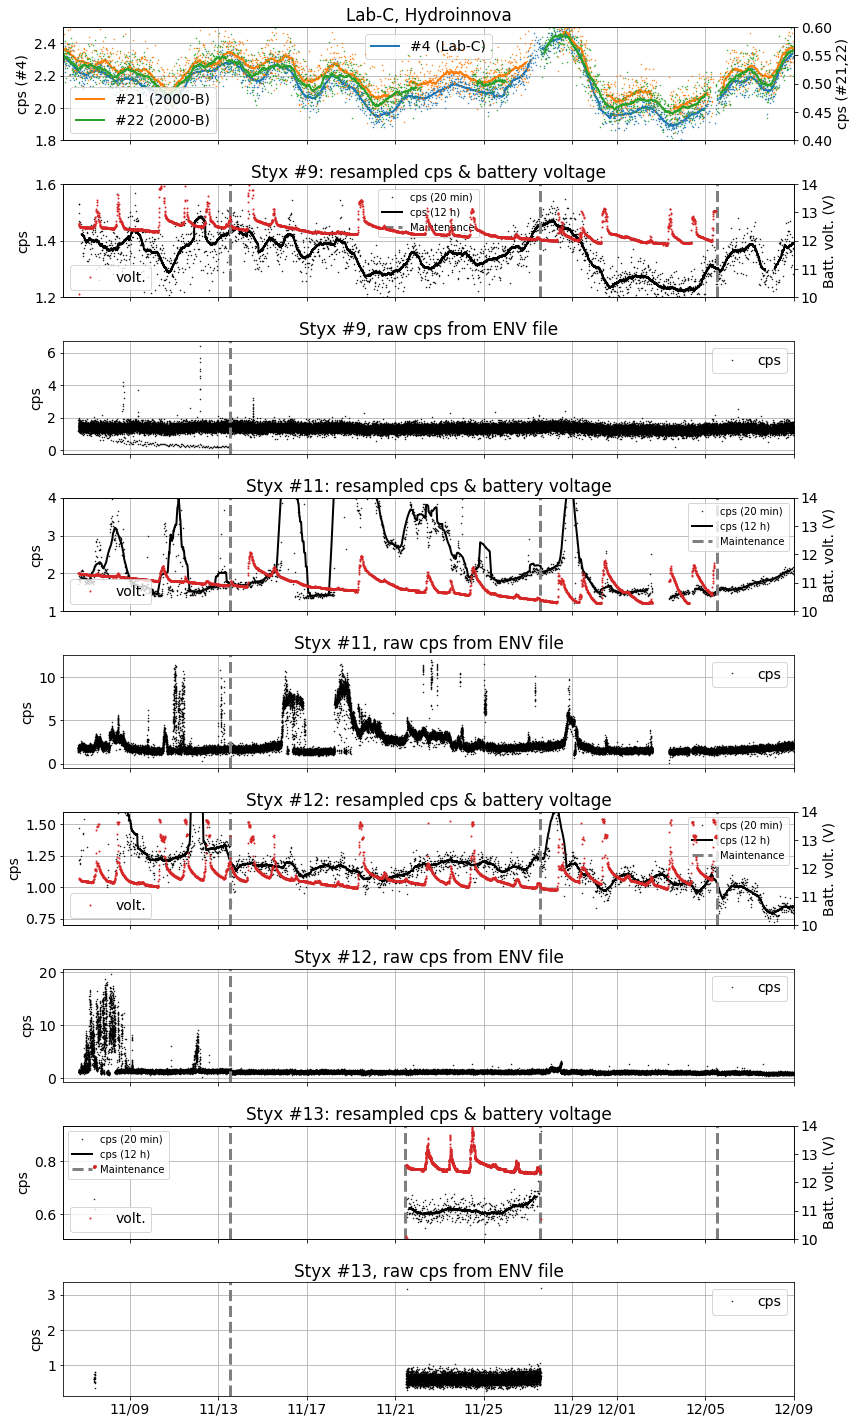

In [39]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(12,20), sharex=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.plot(crns[4].index, crns[4].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:blue")
tmp = crns[4].rolling("12H", min_periods=12*3).mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:blue", lw=2, label="#4 (Lab-C)")
plt.title("Lab-C, Hydroinnova")
plt.ylabel("cps (#4)")
plt.grid()
plt.ylim(1.8,2.5)
plt.legend()

ax2 = ax[0].twinx()
plt.sca(ax2)
plt.plot(crns[21].index, crns[21].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:orange")
tmp = crns[21].rolling("12H", min_periods=12*3).mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:orange", 
         lw=2, label="#21 (2000-B)")
plt.plot(crns[22].index, crns[22].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:green")
tmp = crns[22].rolling("12H", min_periods=12*3).mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:green", 
         lw=2, label="#22 (2000-B)")
plt.ylim(0.4,0.6)
plt.ylabel("cps (#21,22)")
plt.legend()
#pd.DataFrame.resample()
#plt.grid()

#plt.xlim(styx[9].index[0], styx[9].index[-1])
plt.xlim(dt.datetime(2019,11,6), dt.datetime(2019,12,9))

i=0
for id in [9,11,12,13]:
    i += 1
    plt.sca(ax[i])
    tmp = styx[id].resample('20T').mean()
    plt.plot(tmp.index+dt.timedelta(seconds=10*60), tmp.cps, linestyle="None", marker=".", ms=1, 
             color="black", label="cps (20 min)")
    tmp = styx[id].rolling("12H", min_periods=int(0.8*12*60)).mean()
    plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cps, linestyle="-", ms=0, color="black",
             lw=2, label="cps (12 h)")
    plt.axvline(dt.datetime(2019,11,13,13), color="grey", label="Maintenance", ls="--", lw=3)
    plt.axvline(dt.datetime(2019,11,27,13), color="grey", label="_Maintenance", ls="--", lw=3)
    plt.axvline(dt.datetime(2019,12,5,13), color="grey", label="_Maintenance", ls="--", lw=3)
    if id==13:
        plt.axvline(dt.datetime(2019,11,21,10), color="grey", label="_Maintenance", ls="--", lw=3)
    plt.legend(fontsize=10)
    #plt.axvline(dt.datetime(2019,11,13,14), color="tab:red")
    plt.grid()
    if id==9:
        plt.ylim(1.2,1.6)
    if id==11:
        plt.ylim(1.0,4)
    if id==12:
        plt.ylim(0.7,1.6)    
    #plt.ylim(0.5,2)
    plt.title("Styx #%d: resampled cps & battery voltage" % id)
    plt.ylabel("cps")
    ax2 = ax[i].twinx()
    plt.sca(ax2)
    plt.plot(styx_hv[id].index, styx_hv[id].volt, linestyle="None", marker=".", ms=2, 
             color="tab:red", label="volt.")
    plt.ylim(10,14)
    plt.ylabel("Batt. volt. (V)")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.legend(loc="lower left")
    i += 1
    plt.sca(ax[i])
    plt.plot(styx[id].index, styx[id].cps, linestyle="None", marker=".", ms=1, color="black", label="cps")
    plt.title("Styx #%d, raw cps from ENV file" % id)
    plt.grid()
    plt.axvline(dt.datetime(2019,11,13,13), color="grey", ls="--", lw=3)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.legend()
    plt.ylabel("cps")
plt.tight_layout()

plt.savefig("styx_mq.pdf", dpi=300, bbox_inches="tight")

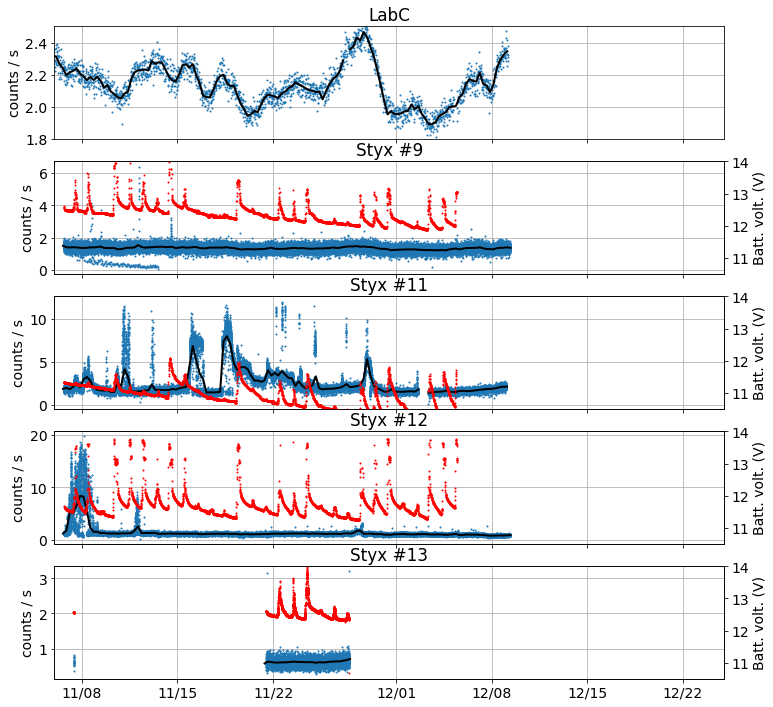

In [35]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12,12), sharex=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.plot(crns[4].index, crns[4].cph1/3600, linestyle="None", marker=".", ms=2)
tmp = crns[4].resample('6H').mean()
plt.plot(tmp.index+dt.timedelta(seconds=3*3600), tmp.cph1/3600, linestyle="-", ms=0, color="black", lw=2)

plt.grid()
plt.ylim(1.8,2.5)
plt.title("LabC")
plt.ylabel("counts / s")
#plt.xlim(styx[9].index[0], styx[9].index[-1])
plt.xlim(dt.datetime(2019,11,6), dt.datetime(2019,12,25))

for i, id in enumerate([9,11,12,13]):
    plt.sca(ax[i+1])
    #tmp = styx[id].resample('20T').mean()
    plt.plot(styx[id].index, styx[id].cps, linestyle="None", marker=".", ms=2)
    tmp = styx[id].resample('6H').mean()
    plt.plot(tmp.index+dt.timedelta(seconds=3*3600), tmp.cps, linestyle="-", ms=0, color="black", lw=2)
    plt.grid()
#     if id==9:
#         plt.ylim(1.2,1.6)
#     if id==11:
#         plt.ylim(1.0,4)
#     if id==12:
#         plt.ylim(1,1.6)    
    #plt.ylim(0.5,2)
    plt.title("Styx #%d" % id)
    plt.ylabel("counts / s")
    ax2 = ax[i+1].twinx()
    plt.sca(ax2)
    plt.plot(styx_hv[id].index, styx_hv[id].volt, linestyle="None", marker=".", color="red", ms=2)
    plt.ylim(10.5,14)
    plt.ylabel("Batt. volt. (V)")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [37]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/styx_reproc_markus_20191218"
names = ["9_allSensorData20191205.dat",
         "11_allSensorData20191205.dat",
         "12_allSensorData20191205.dat",
         "13_allSensorData20191127.dat"]
ids = [9,11,12,13]
styx_reproc = {}
columns = ["datetime","ncounts","interval","pressure","temperature","relhumidity","volt","hvvoltage","nCatchertemperature","filenumber"]
for i, id in enumerate(ids):
    df = pd.read_csv(path.join(fpath, names[i]), sep=";")
    df.columns = columns
    df.datetime = [dt.datetime.utcfromtimestamp(dtime) for dtime in df.datetime]
    #df.datetime = pd.to_datetime("datetime")
    df = df.set_index("datetime")
    #df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
    print(id, end=": ")
    try:
        print("%s to %s" % (df.index[0], df.index[-1]) )
    except:
        print("empty")
    df["cps"] = df.ncounts / df.interval
    styx_reproc[id] = df

9: 2019-11-06 16:43:55 to 2019-12-05 10:37:16
11: 2019-11-21 13:20:02 to 2019-12-05 09:12:48
12: 2019-11-06 17:21:06 to 2019-12-05 11:09:43
13: 2019-11-21 12:49:56 to 2019-11-27 12:58:41


In [43]:
styx_reproc[9][0:30]

,ncounts,interval,pressure,temperature,relhumidity,volt,hvvoltage,nCatchertemperature,filenumber,cps
datetime,,,,,,,,,,
2019-11-06 16:43:55,1386,1200,100047.48,8.130,100.0,12.58,846.5,12.53,8,1.155000
2019-11-06 17:03:58,1277,1200,100063.93,8.188,100.0,12.55,845.0,12.46,8,1.064167
2019-11-06 17:24:09,1274,1200,100063.75,8.259,100.0,12.51,755.5,12.44,8,1.061667
2019-11-06 17:44:14,1315,1200,100076.38,8.300,100.0,12.48,722.5,12.38,9,1.095833
2019-11-06 18:04:16,1298,1200,100090.48,8.032,100.0,12.48,1171.0,12.38,9,1.081667
2019-11-06 18:24:18,1284,1200,100098.92,7.858,100.0,12.48,1171.0,12.31,9,1.070000
2019-11-06 18:44:21,1274,1200,100100.39,7.730,100.0,12.48,1171.0,12.28,10,1.061667
2019-11-06 19:04:23,1274,1200,100115.79,7.481,100.0,12.48,585.5,12.25,10,1.061667
2019-11-06 19:24:25,1268,1200,100136.56,7.347,100.0,12.48,1171.0,12.19,10,1.056667


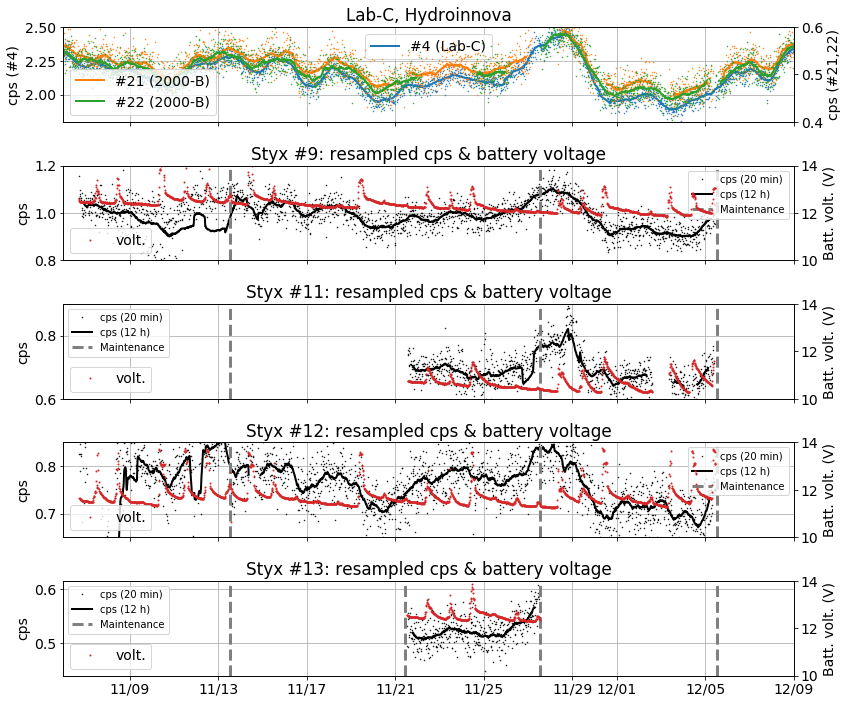

In [62]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12,10), sharex=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.plot(crns[4].index, crns[4].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:blue")
tmp = crns[4].rolling("12H").mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:blue", lw=2, label="#4 (Lab-C)")
plt.title("Lab-C, Hydroinnova")
plt.ylabel("cps (#4)")
plt.grid()
plt.ylim(1.8,2.5)
plt.legend()

ax2 = ax[0].twinx()
plt.sca(ax2)
plt.plot(crns[21].index, crns[21].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:orange")
tmp = crns[21].rolling("12H", min_periods=12*3).mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:orange", 
         lw=2, label="#21 (2000-B)")
plt.plot(crns[22].index, crns[22].cph1/3600, linestyle="None", marker=".", ms=1, color="tab:green")
tmp = crns[22].rolling("12H", min_periods=12*3).mean()
plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cph1/3600, linestyle="-", ms=0, color="tab:green", 
         lw=2, label="#22 (2000-B)")
plt.ylim(0.4,0.6)
plt.ylabel("cps (#21,22)")
plt.legend()
#pd.DataFrame.resample()
#plt.grid()

#plt.xlim(styx[9].index[0], styx[9].index[-1])
plt.xlim(dt.datetime(2019,11,6), dt.datetime(2019,12,9))

i=0
for id in [9,11,12,13]:
    i += 1
    plt.sca(ax[i])
    #tmp = styx_reproc[id]
    plt.plot(styx_reproc[id].index, styx_reproc[id].cps, linestyle="None", marker=".", ms=1, 
             color="black", label="cps (20 min)")
    tmp = styx_reproc[id].rolling("12H", min_periods=12*3).mean()
    plt.plot(tmp.index-dt.timedelta(seconds=6*3600), tmp.cps, linestyle="-", ms=0, color="black",
             lw=2, label="cps (12 h)")
    plt.axvline(dt.datetime(2019,11,13,13), color="grey", label="Maintenance", ls="--", lw=3)
    plt.axvline(dt.datetime(2019,11,27,13), color="grey", label="_Maintenance", ls="--", lw=3)
    plt.axvline(dt.datetime(2019,12,5,13), color="grey", label="_Maintenance", ls="--", lw=3)
    if id==13:
        plt.axvline(dt.datetime(2019,11,21,10), color="grey", label="_Maintenance", ls="--", lw=3)
    plt.legend(fontsize=10)
    #plt.axvline(dt.datetime(2019,11,13,14), color="tab:red")
    plt.grid()
    if id==9:
        plt.ylim(0.8,1.2)
    if id==11:
        plt.ylim(0.6,0.9)
    if id==12:
        plt.ylim(0.65,0.85)    
    #plt.ylim(0.5,2)
    plt.title("Styx #%d: resampled cps & battery voltage" % id)
    plt.ylabel("cps")
    ax2 = ax[i].twinx()
    plt.sca(ax2)
    plt.plot(styx_reproc[id].index, styx_reproc[id].volt, linestyle="None", marker=".", ms=2, 
             color="tab:red", label="volt.")
    plt.ylim(10,14)
    plt.ylabel("Batt. volt. (V)")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.legend(loc="lower left")
#     i += 1
#     plt.sca(ax[i])
#     plt.plot(styx_reproc[id].index, styx_reproc[id].cps, linestyle="None", marker=".", ms=1, color="black", label="cps")
#     plt.title("Styx #%d, raw cps from ENV file" % id)
#     plt.grid()
#     plt.axvline(dt.datetime(2019,11,13,13), color="grey", ls="--", lw=3)
#     ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#     plt.legend()
#     plt.ylabel("cps")
plt.tight_layout()

#plt.savefig("styx_mq_reproc.pdf", dpi=300, bbox_inches="tight")